In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from utils.utils import p2Z
import utils.set_matplotlib_default

: 

In [71]:
# Hyperparameters for this run
seed=1
n_trials = 10000
n_trials_sig = 100
save_directory = "gf_results/"
test_stat="MLSnormal_positiv"
fff = "4_param"
n_dof=16-4
method="trf"
nfev=100000
binning=np.linspace(3000, 4600, 17)
random_resampling_type="bootstrap_true"
sig_fractions = [0.1, 0.075, 0.05, 0.03, 0.025, 0.024, 0.023, 0.022, 0.02, 0.019, 0.018, 0.017, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.002, 0.001]
#sig_fractions = [0.075, 0.05, 0.025, 0.02, 0.015, 0.01, 0.008, 0.007, 0.005]

In [53]:
np.random.seed(seed)
save_name = test_stat+fff+random_resampling_type+str(n_trials) +"x"+str(n_trials_sig)+"_binning"+str(len(binning)-1)

In [54]:
from utils.test_statistics import MLSnormal_positiv, chi_square

if test_stat=="MLSnormal_positiv":
	test_stat_f = MLSnormal_positiv
elif test_stat=="chi_square":
	test_stat_f = chi_square
elif test_stat=="chi_square_n_dof":
	test_stat_f = lambda x, y: chi_square(x, y)/n_dof


In [55]:
from numpy.random import choice
def random_resampling_normal(y, y_err):
    return np.random.normal(y, y_err)

def random_resampling_bootstrap_in_spectrum(y, y_err, actual_total=None):
	if actual_total is None:
		number = round(sum(y))
	else:
		number = round(np.sum(choice(np.array([0, 1]), actual_total, p=[1-round(sum(y))/actual_total, round(sum(y))/actual_total])))
	#print(number)
	draw = choice(list(range(len(y))), round(number), p=y/sum(y))
	y_new = np.bincount(draw)
	return y_new


if random_resampling_type=="normal":
	random_resampling = random_resampling_normal
if random_resampling_type=="bootstrap_in_spectrum":
	random_resampling = random_resampling_bootstrap_in_spectrum
if random_resampling_type=="bootstrap_true":
	random_resampling = lambda x, y: random_resampling_bootstrap_in_spectrum(x, y, actual_total=1000000)



In [56]:
def smample_signal(mjj_signal, sig_fraction, binning):
    n = int(len(mjj_signal)*sig_fraction)
    m_chosen = np.random.choice(mjj_signal, n, replace=False)
    sig = np.histogram(m_chosen, bins=binning)[0]
    return sig 

In [57]:
#Load the mass spectra
data_path = "../../DATA/LHCO/"
mjj_bg = np.load(data_path + "mjj_bkg_sort.npy")
mjj_sg = np.load(data_path + "mjj_sig_sort.npy")

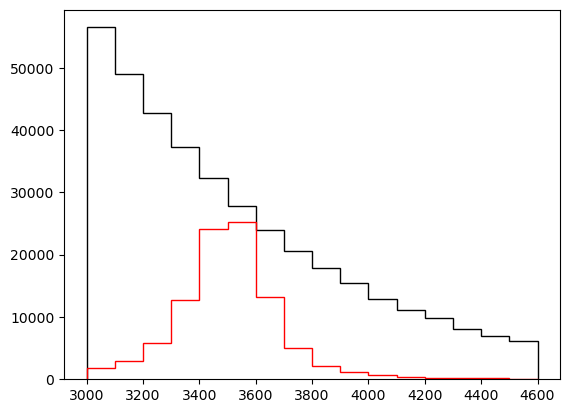

In [58]:
bkg = plt.hist(mjj_bg, bins=binning, range=(3000, 4600), histtype="step", color="black")
bkg = bkg[0]
sig = plt.hist(mjj_sg, bins=binning, range=(3000, 4600), histtype="step", color="red")
sig = sig[0]

In [59]:
x=np.linspace(3000, 4600, 17)
x=x[:-1]+(x[1]-x[0])/2

In [60]:
bkg_err = np.sqrt(bkg)
sig_err = np.sqrt(sig)

In [61]:
y_orig_err=np.sqrt(bkg_err**2)

In [62]:
s=13000
def fit(x, y, y_err, fff, s=13000):
	if fff == "5_param":
		f = (
				lambda x, p1, p2, p3, p4: p1
				* (1 - x / s) ** p2
				* (x / s) ** (p3 + p4 * np.log(x / s)+p5*np.log(x / s)**2)
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[2.067e7, 1.368, 0, 0, 0],
			bounds=(
				[0, -1000, -1000, -1000, -1000],
				[1000000000, 1000, 1000, 1000, 1000],
			),
			method=method,
			max_nfev=nfev,
		)
	elif fff == "4_param":
		f = (
				lambda x, p1, p2, p3, p4: p1
				* (1 - x / s) ** p2
				* (x / s) ** (p3 + p4 * np.log(x / s))
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[0.1523, 0.8516, -14.178, -3.57],
			bounds=(
				[0, -1000, -20, -20],
				[1000000000, 1000, 20, 20],
			),
			method=method,
			max_nfev=nfev,
		)
	elif fff == "3_param":
		f = (
				lambda x, p1, p2, p3: p1
				* (1 - x / s) ** p2
				* (x / s) ** p3
			)
		rrr = scipy.optimize.curve_fit(
			f,
			x,
			y,
			sigma=y_err,
			p0=[2.21e7, 1.376, -0.00968],
			bounds=(
				[0, -1000, -1000],
				[1000000000, 1000, 1000],
			),
			method=method,
		)
	return rrr, f



In [63]:
rrr, f = fit(x, bkg, y_orig_err, fff, s=13000)
fited_bkg = f(x, *rrr[0])
print(rrr)

(array([  0.15239691,   0.85218256, -14.17770188,  -3.57107481]), array([[ 2.55535048, 13.13983622, 14.39623526,  3.62542291],
       [13.13983622, 67.60102894, 73.9951363 , 18.62472271],
       [14.39623526, 73.9951363 , 81.13386394, 20.44086954],
       [ 3.62542291, 18.62472271, 20.44086954,  5.15257668]]))


1.392739990905755
1.2029708407797537
1.392739990905755


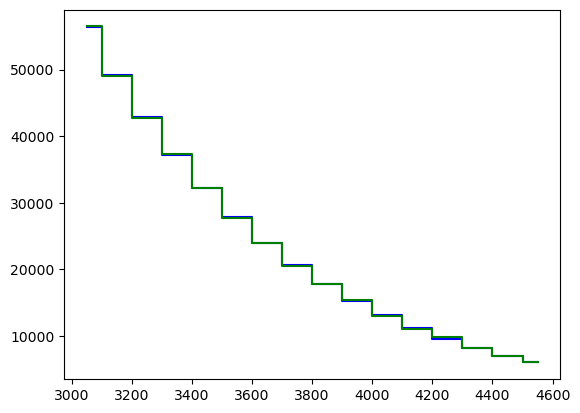

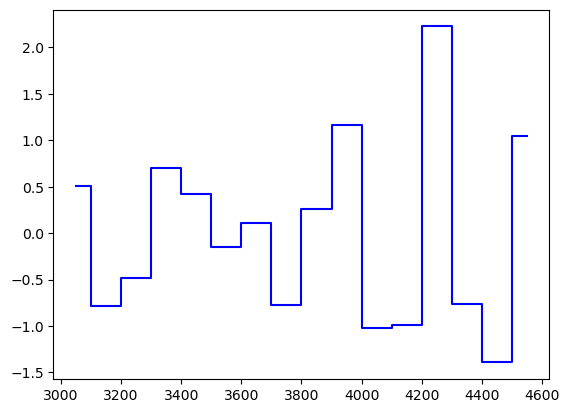

In [64]:
plt.step(x, fited_bkg, color="blue", where="mid")
plt.step(x, bkg, color="green", where="mid")
plt.figure()
plt.step(x, (bkg-fited_bkg)/y_orig_err, color="blue", where="mid")
print(MLSnormal_positiv(bkg, fited_bkg))
k = len(bkg)
print(np.sum((bkg-fited_bkg)**2/y_orig_err**2)/n_dof)
print(test_stat_f(bkg, fited_bkg))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot histogram and fit on ax1
ax1.step(x, bkg, color="green", where="mid" label="Data")
ax1.step(x, fited_bkg, color="blue", where="mid", label='4 parameter fit')

ax1.legend()
ax1.set_xlabel('$m_{jj}$')
ax1.set_ylabel('Counts')

# Calculate the difference between histogram and fit
diff = hist - gaussian(bin_centers, *params)

# Plot the difference on ax2
ax2.step(x, (bkg-fited_bkg)/y_orig_err, color="blue", where="mid")
ax2.axhline(0, color='gray', linestyle='dashed')
ax2.legend()
ax2.set_xlabel('$m_{jj}$')
ax2.set_ylabel('Difference in SD')

plt.tight_layout()
plt.show()

In [65]:
test = np.max((bkg-fited_bkg)**2/y_orig_err**2)
print(test)

4.950091943384801


In [66]:
def get_tests_fit(y_orig, n_trials, signal_fraction=None):
    y_orig_err = np.sqrt(y_orig)
    tests=[]
    for i in range(n_trials):
        if signal_fraction is not None:
            y = random_resampling(y_orig, y_orig_err) + smample_signal(mjj_sg, signal_fraction, binning)
        else:
            y = random_resampling(y_orig, y_orig_err)
        rrr, f = fit(x, y, y_orig_err, fff, s=13000)
        fited = f(x, *rrr[0])
        test = test_stat_f(fited, y)
        tests.append(test)
    return tests

tests_bg = get_tests_fit(fited_bkg, n_trials)

In [72]:
tests_sg_f = []
for sig_fraction in sig_fractions:
	tests_sg_f.append(get_tests_fit(fited_bkg, n_trials_sig, signal_fraction=sig_fraction))

tests_sg_f = np.array(tests_sg_f)

1.5947331722371847


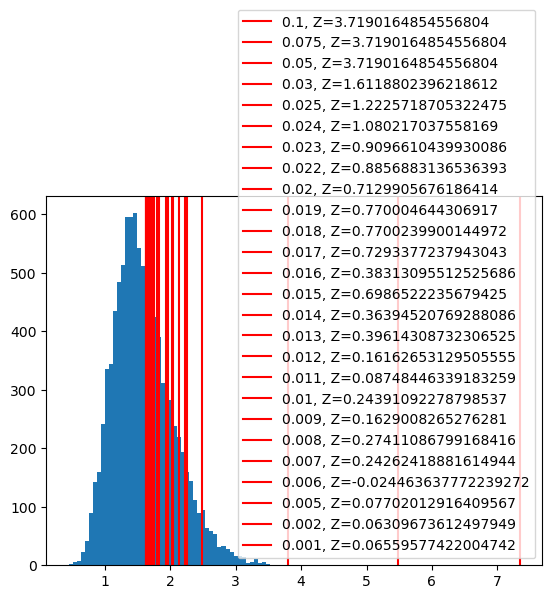

In [73]:
plt.hist(tests_bg, bins=50)
print(np.mean(tests_bg))
Zs = []
Zs_low = []
Zs_high = []
for i in range(len(sig_fractions)):
	ps = [1-np.mean(test>tests_bg) for test in tests_sg_f[i]]
	ps = np.array(ps)
	ps[ps==0]=1/n_trials
	Zs.append(p2Z(ps))
	plt.axvline(np.mean(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, Z={np.median(Zs[i])}")
plt.legend()

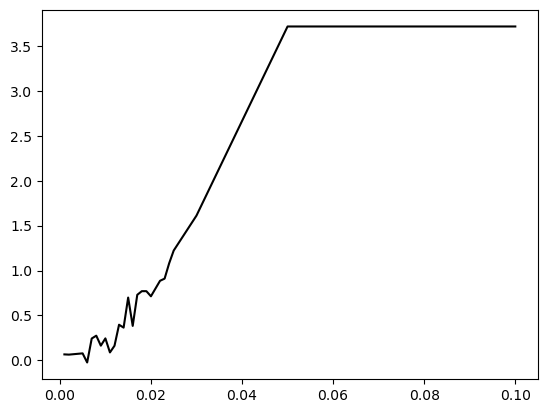

In [74]:
plt.plot(sig_fractions, [np.median(Zs_) for Zs_ in Zs], color="black")

In [75]:
import pickle
pickle.dump({"sig_fractions": np.array(sig_fractions), "Zs": np.array(Zs)}, open(save_directory+save_name+"_Zs.pickle", "wb"))

Now make everything Idealised 

In [46]:
def get_tests(y_orig, n_trials, signal_fraction=None):
    y_orig_err = np.sqrt(y_orig)
    tests=[]
    for i in range(n_trials):
        if signal_fraction is not None:
            y = random_resampling(y_orig, y_orig_err) + smample_signal(mjj_sg, signal_fraction, binning)
        else:
            y = random_resampling(y_orig, y_orig_err)
        test = test_stat_f(y_orig, y)
        tests.append(test)
    return tests

tests_bg = get_tests(bkg, n_trials)


In [47]:

tests_sg_f = []
for sig_fraction in sig_fractions:
	tests_sg_f.append(get_tests(bkg, n_trials_sig, signal_fraction=sig_fraction))

tests_sg_f = np.array(tests_sg_f)

1.7919456971251477


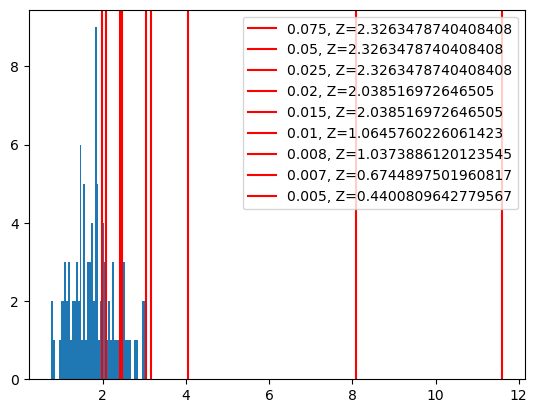

In [48]:
plt.hist(tests_bg, bins=50)
print(np.mean(tests_bg))
Zs = []
Zs_low = []
Zs_high = []
for i in range(len(sig_fractions)):
	ps = [1-np.mean(test>tests_bg) for test in tests_sg_f[i]]
	ps = np.array(ps)
	ps[ps==0]=1/n_trials
	Zs.append(p2Z(ps))
	plt.axvline(np.mean(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, Z={np.median(Zs[i])}")
	#plt.axvline(np.median(tests_sg_f[i]), color="red", label=f"{sig_fractions[i]}, p={np.mean(np.median(tests_sg_f[i])>tests_bg)}")
plt.legend()
plt.figure()
plt.plot(sig_fractions, [np.median(Zs_) for Zs_ in Zs], color="black")
pickle.dump({"sig_fractions": np.array(sig_fractions), "Zs": np.array(Zs)}, open(save_directory+save_name+"_Zs_ideal.pickle", "wb"))